# СТОЛБЕЦ - ТИП РАСПРЕДЕЛЕНИЯ

анализ проводился при замене пропусков на медиану признка. Выбросы удалены методом межкванитлного размаха.

В конце блокнота будет важный матричный график

*   stage_1_output_konv_avd - нормальное распределение
------------------------------------------------------
*   stage_2_input_water_sum - нормальное распределение

*   stage_2_output_bottom_pressure - НЕ нормальное распределение

*   stage_2_output_bottom_temp - нормальное распределение

*   stage_2_output_bottom_temp_hum_steam - НЕ нормальное распределение

*   stage_2_output_bottom_vacuum - ВРОДЕ нормальное распределение

*   stage_2_output_top_pressure - нормальное распределение

*   stage_2_output_top_pressure_at_end - нормальное распределение

*   stage_2_output_top_temp - НЕ нормальное распредление

*   stage_2_output_top_vacuum - НЕ нормальное распределение
------------------------------------------------------

*   stage_3_input_pressure - НЕ нормальное распределение

*   stage_3_input_soft_water - НЕ нормальное распределение

*   stage_3_input_steam - НЕ нормальное распределение

*   stage_3_output_temp_hum_steam - НЕ нормальное распределение

*   stage_3_output_temp_top - НЕ нормальное распределение
------------------------------------------------------
*   stage_4_input_overheated_steam - НЕ нормальное распределение

*   stage_4_input_polymer - ВРОДЕ нормальное распределение

*   stage_4_input_steam - НЕ нормальное распределение

*   stage_4_input_water - НЕ нормальное распределение

*   stage_4_output_dry_residue_avg - ВРОДЕ нормальное распределение

*   stage_4_output_product - НЕ нормальное распределение




# БАЗА
без этого работать не будет

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import spearmanr, mannwhitneyu
import matplotlib.pyplot as plt

отброска выбросов с помощью IQR

In [6]:
def iqr_filter(df: pd.DataFrame, column: str, lower_bound=True, upper_bound=True, multp=3):
  """
  гибкая функция для удаления выбросов с помощью настраиваемого интерквартильного размаха

  Аргументы
      df: DataFrame содержащий данные, которые нужно отфильтровать.

      column: Название столбца в DataFrame df, в которомом будет производиться фильтрация.
      Функция будет рассчитывать IQR именно для этого столбца.

      lower_bound:  Булевый флаг, определяющий, следует ли отфильтровывать значения,
      лежащие ниже нижней границы, рассчитанной на основе IQR. То есть, если
      lower_bound = False, то все выбросы(если они есть) будут игнорироваться.

      upper_bound: Булевый флаг, определяющий, следует ли отфильтровывать значения,
      лежащие выше верхней границы, рассчитанной на основе IQR.

      multp: Множитель, используемый для расчета границ фильтрации.
  """
  q1, q3 = np.percentile(df[column], [25, 75])
  iqr = (q3 - q1) * multp
  low_bound = q1 - iqr
  up_bound = q3 + iqr

  median = 0 # медиана
  outlines = 0 # индексы, значения строк столбца которых необходимо заменить медианой

  # в этих ситуациях мы ищем медиану чисел, которые не считаем за выбросы (1)
  # то есть мы считаем за выбросы up_bound или/и low_bound и не используем их диапазон значений
  # для поиска медианы.
  if lower_bound and upper_bound:
    outlines = df[(df[column] < low_bound) | (df[column] > up_bound)].index
    median = df[(df[column] >= low_bound) & (df[column] <= up_bound)][column].median() # та самая медиана (1)
  elif lower_bound:
    outlines = df[df[column] < low_bound].index
    median = df[df[column] >= low_bound][column].median() # та самая медиана (1)
  elif upper_bound:
    outlines = df[df[column] > up_bound].index
    median = df[df[column] <= up_bound][column].median() # та самая медиана (1)

  df.loc[outlines, column] = median


####################################################################################################


def find_dependencies(correlation_matrix, threshold=0.5):
    """
    Выводит пары зависимых признаков на основе матрицы корреляции.

    Аргументы:
        correlation_matrix: Pandas DataFrame с матрицей корреляции.
        threshold: Порог корреляции для определения зависимости.
    """

    dependent_features = {} # словарь для хранения выявленных зависимостей.

    for feature in correlation_matrix.columns:  # цикл переберает все столбцы в матрице
        correlations = correlation_matrix[feature] # для текущей feature эта строка извлекает
                                                   # значения корреляции этой функции со всеми
                                                   # остальными функциями в виде pd.Series .
        dependencies = correlations[correlations.abs() >= threshold].index.tolist() # основная логика
        #correlations.abs() >= threshold: Это создаёт логическую маску, которая выбирает только
        #значения корреляции, которые по модулю абсолютного значения больше или равны threshold.
        #.index.tolist(): .index извлекает индексы (имена признаков), соответствующие
        #выбранным значениям корреляции, и .tolist() преобразует эти индексы в список.


        if dependencies:  # если есть зависимости
          dependencies.remove(feature) # удаляем зависимость с самим собой
          dependent_features[feature] = dependencies # выявленные зависимости сохраняются
                                                     # в словаре dependent_features.
                                                     # Текущий признак становится ключом,
                                                     # а список его зависимостей — значением.
    return dependent_features # пары зависимых признаков на основе матрицы корреляции.


####################################################################################################


def visualize_correlation_matrix(correlation_matrix, title="The best graphic"): # красивый график ВСЕХ корреляций(колличественных)
    """
    Рисует график корреляций всех колличественных признаков(и не только, если надо).

    Аругменты:
        correlation_matrix:  Фрейм данных Pandas, представляющий корреляционную матрицу.
        threshold: Название графика.
    """
    for col in correlation_matrix.columns: # цикл повторяется по каждому столбцу корреляционной матрицы.
        correlation_matrix[col] = pd.to_numeric(correlation_matrix[col], errors='coerce') # спасает от вылета программы.

    #correlation_matrix_np = correlation_matrix.values # преобразует фрейм данных Pandas в массив NumPy

    plt.figure(figsize=(10, 8))
    plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest') # создание тепловой карты корреляций

    plt.colorbar(label='Correlation')

    plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
    plt.yticks(range(len(correlation_matrix.index)), correlation_matrix.index)

    plt.title(title)
    plt.show()

In [7]:
df_environmental_data = pd.read_csv("analysing_environmental_issues.csv", sep=',') # главный датафрейм

In [8]:
df_environmental_data

,DateTime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
0,2021-01-28 18:00:00,67.83,92.99,474.18,76.84,97.52,49.94,361.50,252.04,97.48,...,108.65,45.59,156.67,19.08,5.92,356.05,NaN,21.48,47.03,2.0
1,2021-01-28 19:00:00,67.83,91.82,473.68,76.15,97.82,48.55,354.75,244.87,97.66,...,108.71,45.89,156.76,19.15,5.94,357.69,NaN,21.48,45.05,2.0
2,2021-01-28 20:00:00,67.83,90.65,473.17,75.46,98.12,47.15,348.00,237.70,97.85,...,108.76,46.19,156.86,19.23,5.97,359.33,NaN,21.48,43.06,2.0
3,2021-01-28 21:00:00,67.93,90.24,473.59,75.26,97.79,49.33,356.74,249.87,97.50,...,108.63,45.87,156.41,19.36,5.97,339.99,0.16,21.48,46.01,2.0
4,2021-01-28 22:00:00,68.03,89.84,474.00,75.06,97.46,51.51,365.49,262.04,97.15,...,108.51,45.54,155.96,19.49,5.97,320.64,NaN,21.48,48.95,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4395,2023-03-19 12:00:00,67.33,43.32,409.32,82.00,105.65,69.35,771.29,223.71,97.37,...,111.26,41.04,152.90,22.69,4.14,381.37,0.20,21.18,9.17,2.0
4396,2023-03-20 00:00:00,68.83,62.24,377.84,79.82,104.80,61.08,781.76,183.36,97.70,...,110.09,46.40,152.53,21.38,4.15,381.77,0.14,21.08,10.79,2.0
4397,2023-03-20 12:00:00,66.83,61.92,397.95,81.19,105.50,66.26,776.52,227.64,98.31,...,108.65,45.99,152.53,21.78,4.14,391.60,0.20,21.08,9.27,1.0
4398,2023-03-21 01:00:00,70.03,62.80,378.37,79.16,110.50,63.16,845.66,223.15,103.01,...,108.18,47.70,151.80,22.44,3.66,460.04,0.18,22.38,10.11,1.0


Делаю тестовый датафрейм, в котором все пропуски заменены медианой.

In [9]:
df2 = df_environmental_data.copy() # копируем главый датафрейм.
df2["DateTime"] = pd.factorize(df2["DateTime"])[0] # Меняем значения столбца на индекс
                                                   # для адекватной работы с этим признаком.
df2.pop("stage_4_output_danger_gas") # значений мало, признак на данном этапе бесполезный.

df2 = df2.drop_duplicates(subset=df2.columns[1:], keep=False) # удаляем все дупликаты.
# Очень важно, что дубликаты будут найдены, если игнорировать столбец "DateTime".

columns_without_nan = [col for col in df2.columns if df2[col].isnull().any() == False]
# Массив с назаниями признаков, в которых НЕТ пропусков значений в датафрейме(без предобработки).

#print(df2.shape) # (4240, 23)

for col in df2.columns: # замена пропусков медианой в каждом столбце
      if df2[col].isnull().any():
        median_val = df2[col].median()
        df2[col] = df2[col].fillna(median_val)

#columns_without_nan
#df2["DateTime"]

убираю выбросы

In [10]:
for i in df2.columns[1:]:
  iqr_filter(df2, i, multp=1.5)

# Проверка корреляции признаков

Это или гениально, или очень глупо.

In [11]:
columns = df2.columns[:-1] # создаём переменную с названиями признаков,
                           # кроме "work_shift", т.к. это бинарный фактор

correlation_matrix_spearman = pd.DataFrame(index=columns, columns=columns) # создаём типо матрицу, корреляцию признаков
                                                                           # которой будем искать методом спирмена.

In [12]:
for chunk in pd.read_csv("analysing_environmental_issues.csv", sep=',', chunksize=750): # считываем все данные
                                                                                        # порциями по 750 строк
  for col in chunk.columns[1:-1]: # замена пропусков медианой в каждом столбце
      median_val = chunk[col].median()
      chunk[col] = chunk[col].fillna(median_val)

  for col1 in columns: # вычисление коэффициентов корелляции для всех пар столбцов
        for col2 in columns:
            corr_spearman, p_value_spearman = spearmanr(chunk[col1], chunk[col2])

            correlation_matrix_spearman.loc[col1, col2] = corr_spearman
            #устанавливаем в качестве значения коэффициенты корреляции в нужную ячейку

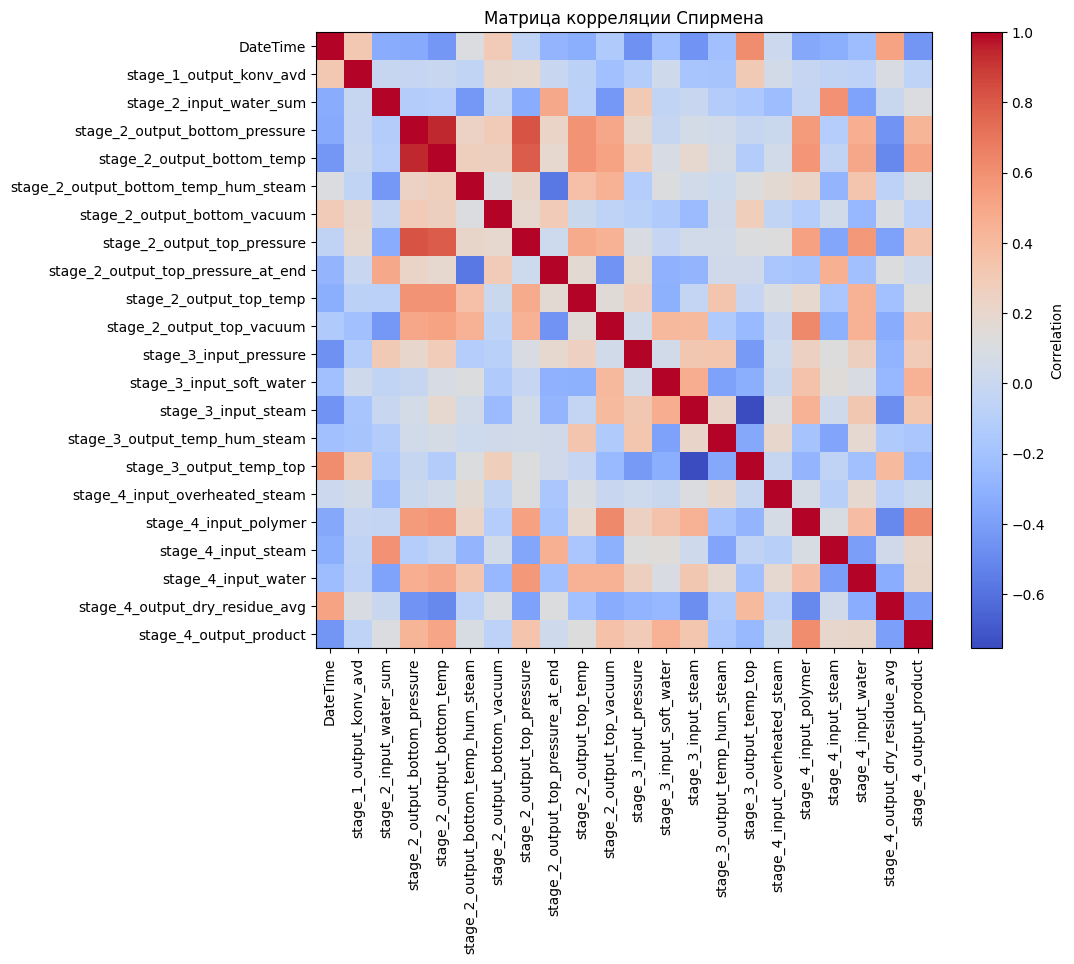

In [13]:
visualize_correlation_matrix(correlation_matrix_spearman, 'Матрица корреляции Спирмена')

In [14]:
dependencies_columns = {}

In [15]:
spearman_dependencies = find_dependencies(correlation_matrix_spearman, threshold=0.55) # пример с порогом 0.5


print("\nЗависимости Спирмена (порог 0.5):\n")
print("-"*150)
for feature, deps in spearman_dependencies.items():
  if feature not in columns_without_nan and deps != []:
    dependencies_columns[feature] = deps

  print(f"| {feature}: {deps}", ' '*(143 - len(feature) - len(str(deps))), "|")
  print("-"*150)


Зависимости Спирмена (порог 0.5):

------------------------------------------------------------------------------------------------------------------------------------------------------
| DateTime: ['stage_3_output_temp_top']                                                                                                              |
------------------------------------------------------------------------------------------------------------------------------------------------------
| stage_1_output_konv_avd: []                                                                                                                        |
------------------------------------------------------------------------------------------------------------------------------------------------------
| stage_2_input_water_sum: ['stage_4_input_steam']                                                                                                   |
----------------------------------------------------------

In [16]:
binary_feature = 'work_shift'  # Замените на название вашего бинарного столбца

quantitative_features = df2.columns[1:-1]
results = {}

for feature in quantitative_features:
  group1 = df2[df2[binary_feature] == 1.0][feature] # группа с 0
  group2 = df2[df2[binary_feature] == 2.0][feature] # группа с 1

  statistic, p_value = mannwhitneyu(group1, group2)
  results[feature] = {'statistic': statistic, 'p_value': p_value}

  if p_value < 0.05:
    if feature not in columns_without_nan:
      if feature not in dependencies_columns:
          dependencies_columns[feature] = [binary_feature]
      else:
        dependencies_columns[feature].append(binary_feature)


# Вывод результатов:
print("Результаты теста Манна-Уитни:")
for feature, res in results.items():
  print(f"{feature}: statistic={res['statistic']:.2f}, p-value={res['p_value']:.3f}")



# Визуализация (пример для одного признака):
#feature_to_visualize = 'stage_2_input_water_sum'  # Выберите признак для визуализации
#plt.figure(figsize=(8, 6))
#sns.boxplot(x=binary_feature, y=feature_to_visualize, data=df2)
#plt.title(f'Boxplot {feature_to_visualize} по группам {binary_feature}')
#plt.show()
df2

Результаты теста Манна-Уитни:
stage_1_output_konv_avd: statistic=2217632.00, p-value=0.498
stage_2_input_water_sum: statistic=2349869.00, p-value=0.008
stage_2_output_bottom_pressure: statistic=2269382.50, p-value=0.534
stage_2_output_bottom_temp: statistic=2182869.50, p-value=0.121
stage_2_output_bottom_temp_hum_steam: statistic=2272782.50, p-value=0.479
stage_2_output_bottom_vacuum: statistic=2048094.00, p-value=0.000
stage_2_output_top_pressure: statistic=2236890.00, p-value=0.846
stage_2_output_top_pressure_at_end: statistic=2227450.50, p-value=0.667
stage_2_output_top_temp: statistic=2340946.00, p-value=0.015
stage_2_output_top_vacuum: statistic=2219121.00, p-value=0.522
stage_3_input_pressure: statistic=2353137.50, p-value=0.006
stage_3_input_soft_water: statistic=2102968.00, p-value=0.000
stage_3_input_steam: statistic=2225961.50, p-value=0.640
stage_3_output_temp_hum_steam: statistic=2127815.50, p-value=0.003
stage_3_output_temp_top: statistic=2253393.50, p-value=0.825
stage_4_

,DateTime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_input_steam,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
0,0,67.83,92.99,474.18,76.84,97.52,49.94,361.50,252.04,97.48,...,664.93,108.65,45.59,153.13,19.08,5.92,356.05,21.48,47.03,2.0
1,1,67.83,91.82,473.68,76.15,97.82,48.55,354.75,244.87,97.66,...,671.68,108.71,45.89,153.13,19.15,5.94,357.69,21.48,45.05,2.0
2,2,67.83,90.65,473.17,75.46,98.12,47.15,348.00,237.70,97.85,...,678.44,108.76,46.19,153.13,19.23,5.97,359.33,21.48,43.06,2.0
3,3,67.93,90.24,473.59,75.26,97.79,49.33,356.74,249.87,97.50,...,717.99,108.63,45.87,153.13,19.36,5.97,339.99,21.48,46.01,2.0
4,4,68.03,89.84,474.00,75.06,97.46,51.51,365.49,262.04,97.15,...,757.55,108.51,45.54,155.96,19.49,5.97,320.64,21.48,48.95,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4395,4395,67.33,43.32,409.32,82.00,105.65,69.35,434.05,223.71,97.37,...,447.43,111.26,41.04,152.90,22.69,4.14,381.37,21.18,47.87,2.0
4396,4396,68.83,62.24,377.84,79.82,104.80,61.08,434.05,183.36,97.70,...,528.42,110.09,46.40,152.53,21.38,4.15,381.77,21.08,47.87,2.0
4397,4397,66.83,61.92,397.95,81.19,105.50,66.26,434.05,227.64,98.31,...,532.37,108.65,45.99,152.53,21.78,4.14,391.60,21.08,47.87,1.0
4398,4398,70.03,62.80,378.37,79.16,110.50,63.16,434.05,223.15,103.01,...,504.74,108.18,47.70,151.80,22.44,3.66,460.04,22.38,47.87,1.0


In [17]:
dependencies_columns

{'stage_2_input_water_sum': ['stage_4_input_steam', 'work_shift'],
 'stage_2_output_bottom_pressure': ['stage_2_output_bottom_temp',
  'stage_2_output_top_pressure',
  'stage_2_output_top_temp',
  'stage_4_input_polymer'],
 'stage_2_output_bottom_temp': ['stage_2_output_bottom_pressure',
  'stage_2_output_top_pressure',
  'stage_2_output_top_temp',
  'stage_4_input_polymer'],
 'stage_2_output_bottom_temp_hum_steam': ['stage_2_output_top_pressure_at_end'],
 'stage_2_output_top_pressure': ['stage_2_output_bottom_pressure',
  'stage_2_output_bottom_temp',
  'stage_4_input_water'],
 'stage_2_output_top_pressure_at_end': ['stage_2_output_bottom_temp_hum_steam'],
 'stage_2_output_top_temp': ['stage_2_output_bottom_pressure',
  'stage_2_output_bottom_temp',
  'work_shift'],
 'stage_2_output_top_vacuum': ['stage_4_input_polymer'],
 'stage_3_input_steam': ['stage_3_output_temp_top'],
 'stage_3_output_temp_top': ['DateTime', 'stage_3_input_steam'],
 'stage_4_input_polymer': ['stage_2_output_bott

ПОБЕДА

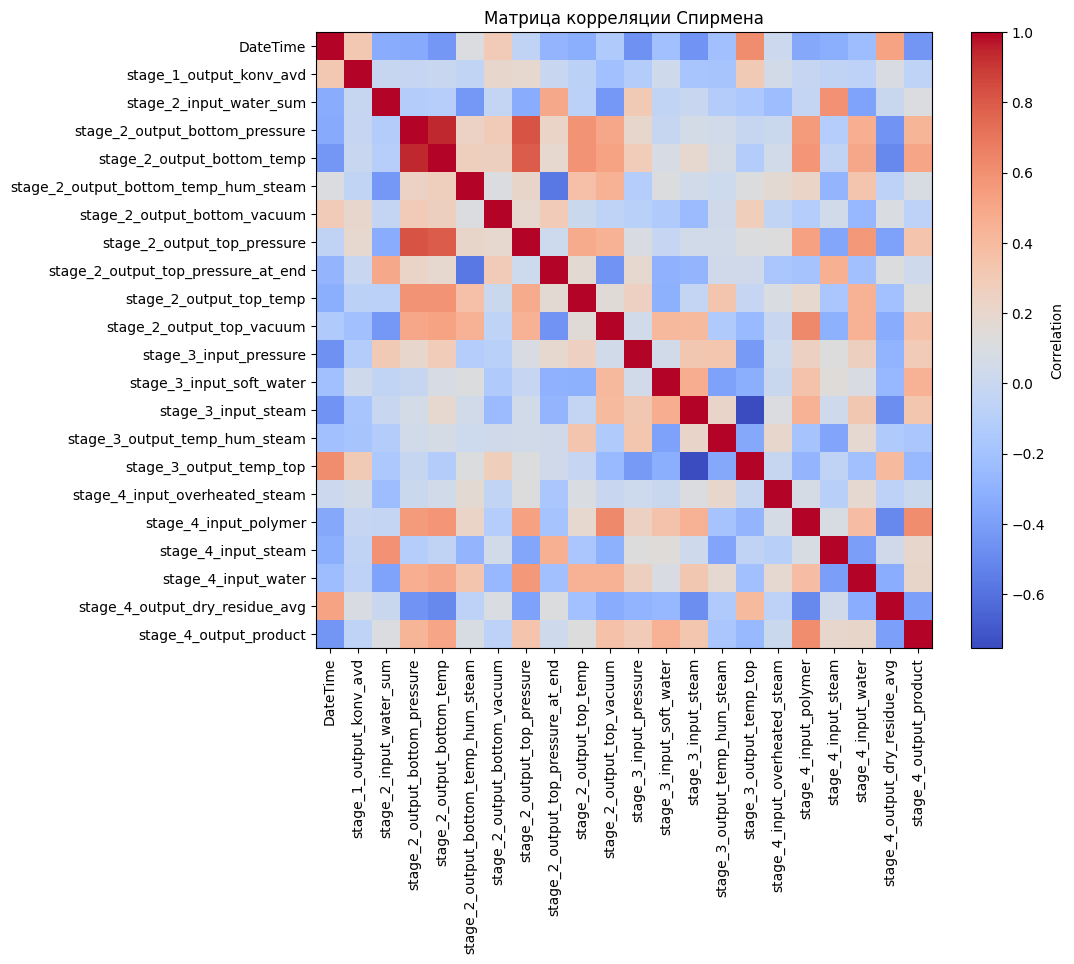

In [18]:
visualize_correlation_matrix(correlation_matrix_spearman, 'Матрица корреляции Спирмена') # Нужно актиировать весь код в блокноте

можно предположить, что при значение x, **когда x > 0.5 или x < -0.5**, существует зависимость между признаками. Можно брать более демократические и радикальные значения, но результат, понятное дело, может отличаться

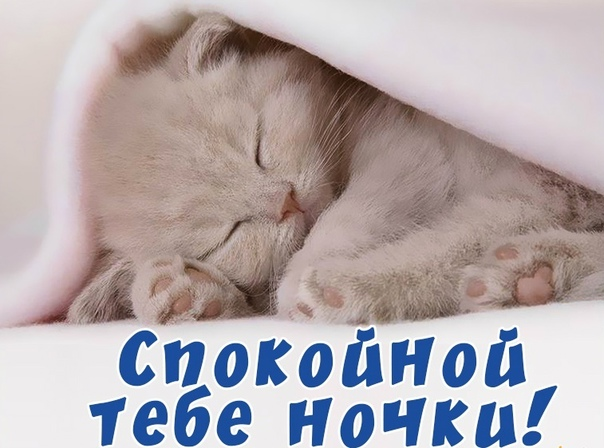